# Building a Minimally Correlated Portfolio with Data Science

The difficulty with modern portfolio theory is that correlations are non-stationary and harbours non-linear effects. On top of that financial data is incredibly sparse and Pearson's correlation only works on time series with equal dimensions. There is accumulating evidence that asset correlation networks, whose nodes are assets and whose edges are the pairwise correlations between the asset's historical returns follows a power-law distribution and show evidence of stationarity. In some sense one can say that these networks are governed by simple scale-free laws. It is known to be hard to forecast financial time series, but maybe the evolution of asset correlation networks is easier to predict if they are driven by simple laws, in which case these laws can be learned by a machine learning algorithm.

In the case of asset correlation networks, we are interested in how volatility spreads between assets between assets and how we can use these insights to optimize our portfolio. To do this we can look at the concept of communicability of complex networks to investigate how things spread and which nodes have the greatest influence in the process. Overall, we will use insights from network science to build centrality-based risk model to generate portfolio asset weights. 


## Summary

Using insights from [Network Science](https://en.wikipedia.org/wiki/Network_science), we build a [centrality-based](https://en.wikipedia.org/wiki/Centrality) risk model for generating portfolio asset weights. The model is trained with the daily prices of 31 stocks from 2006-2014 and validated in years 2015, 2016, and 2017. As a benchmark, we compare the model with a portolfio constructed with [Modern Portfolio Theory (MPT)](https://en.wikipedia.org/wiki/Modern_portfolio_theory). Our proposed asset allocation algorithm significantly outperformed both the DIJIA and S&P500 indexes in every validation year with an average annual return rate of 38.7%, a 18.85% annual volatility, a 1.95 Sharpe ratio, a -12.22% maximum drawdown, a return over maximum drawdown of 9.75, and a growth-risk-ratio of 4.32. In comparison, the MPT portfolio had a 9.64% average annual return rate, a 16.4% annual standard deviation, a Sharpe ratio of 0.47, a maximum drawdown of -20.32%, a return over maximum drawdown of 1.5, and a growth-risk-ratio of 0.69.


### Asset Diversification and Allocation

The building blocks of a portfolio are assets (resources with economic value expected to increase over time). Each asset belongs to one of seven primary asset classes: cash, equitiy, fixed income, commodities, real-estate, alternative assets, and more recently, digital (such as cryptocurrency and blockchain). Within each class are different asset types. For example: stocks, index funds, and equity mutual funds all belong to the equity class while gold, oil, and corn belong to the commodities class. An emerging consensus in the financial sector is this: a portfolio containing assets of many classes and types hedges against potential losses by increasing the number of revenue streams. In general the more diverse the portfolio the less likely it is to lose money. Take stocks for example. A diversified stock portfolio contains positions in multiple sectors. We call this *asset diversification*, or more simply *diversification*. Below is a table summarizing the asset classes and some of their respective types.

Cash | Equity | Fixed Income | Commodities | Real-Estate | Alternative Assets | Digital |
-----|--------|--------------|-------------|-------------|--------------------|---------|
US Dollar | US Stocks | US Bonds | Gold | REIT's | Structured Credit | Cryptocurrencies
Japenese Yen | Foreign Stocks | Foreign Bonds | Oil | Commerical Properties | Liquidations | Security Tokens
Chinese Yaun | Index Funds | Deposits | Wheat | Land | Aviation Assets | Online Stores
UK Pound | Mutual Funds | Debentures | Corn | Industrial Properties | Collectables | Online Media
 &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> |
 &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> | &bull;<p> |

**An investor solves the following (asset allocation) problem: given X dollars and N assets find the best possible way of breaking X into N pieces.** By "best possible" we mean maximizing our returns subject to minimizing the risk of our initial investment. In other words, we aim to consistently grow X irrespective of the overall state of the market. 
   
   A lower annual standard deviation indicates smaller fluctuations in each revenue stream, and in turn a diminished risk exposure. The "Holy Grail" so to speak, is to (1) find the largest number of assets that are the **least** correlated and (2) allocate X dollars to those assets such that the probability of losing money any given year is minimized. The underlying principle is this: the portfolio most robust against large market fluctuations and economic downturns is a portfolio with assets that are the **most independent** of eachother.

In [1]:
#import data manipulation (pandas) and numerical manipulation (numpy) modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#silence warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Get the data
df = pd.read_csv(r"data/20130102_20200529_daily.csv", index_col=0)
df.head()

,Ticker,Open,Low,High,Close,Volume,Name
Day,,,,,,,
2013-01-02,ABCB4,14.00,14.00,14.27,14.15,5224632.0,ABC BRASIL
2013-01-02,ALPA4,15.10,14.98,15.30,15.16,2719722.0,ALPARGATAS
2013-01-02,AMAR3,32.55,32.54,33.01,32.63,7420976.0,LOJAS MARISA
2013-01-02,BBAS3,26.00,25.46,26.19,25.80,220234920.0,BRASIL
2013-01-02,BBDC3,34.30,34.30,35.43,35.11,39184241.0,BRADESCO


In [3]:
stocks = open(r"data/selected_tickers.txt").read().split(",")
np.array(stocks)

array(['ABCB4', 'BBAS3', 'BBDC4', 'BRAP4', 'BRML3', 'BRPR3', 'CCRO3',
       'CMIG4', 'CPFE3', 'CSAN3', 'CSNA3', 'CYRE3', 'DTEX3', 'ECOR3',
       'ELET3', 'ENBR3', 'EQTL3', 'EVEN3', 'EZTC3', 'GFSA3', 'GGBR4',
       'GOAU4', 'GOLL4', 'HYPE3', 'IGTA3', 'ITSA4', 'ITUB4', 'LAME4',
       'LIGT3', 'LREN3', 'MRVE3', 'MULT3', 'PETR4', 'RENT3', 'SBSP3',
       'TCSA3', 'TIMP3', 'UGPA3', 'VALE3', 'VIVT4'], dtype='<U5')

In [4]:
# Filter data with the selected stocks
df = df.loc[df.Ticker.apply(lambda x: x in stocks)]

In [5]:
df.loc[df.index <= "2017-01-02"].index.max()

'2017-01-02'

In [6]:
# Set the ranges for training and testing
from header import TRAIN_RANGE, TEST_RANGE
print(TRAIN_RANGE)
print(TEST_RANGE)

df_train = df.loc[TRAIN_RANGE[0]:TRAIN_RANGE[1]]
df_train.tail()

('2013-01-02', '2016-12-29')
('2017-01-02', '2020-05-29')


,Ticker,Open,Low,High,Close,Volume,Name
Day,,,,,,,
2016-12-29,TCSA3,2.20,2.13,2.21,2.16,3378789.0,TECNISA
2016-12-29,TIMP3,7.78,7.63,7.86,7.83,15766673.0,TIM PART S/A
2016-12-29,UGPA3,67.24,66.60,69.30,68.45,65737657.0,ULTRAPAR
2016-12-29,VALE3,26.68,25.50,26.85,25.68,123590835.0,VALE
2016-12-29,VIVT4,43.38,42.99,44.26,44.08,50084766.0,TELEF BRASIL


In [7]:
#testing dataset
df_validate = df.loc[TEST_RANGE[0]:TEST_RANGE[1]]
df_validate.tail()

,Ticker,Open,Low,High,Close,Volume,Name
Day,,,,,,,
2020-05-29,TCSA3,0.74,0.72,0.75,0.75,6.657817e+06,TECNISA
2020-05-29,TIMP3,13.46,13.16,13.62,13.62,1.465600e+08,TIM PART S/A
2020-05-29,UGPA3,17.39,16.83,17.62,17.12,2.456379e+08,ULTRAPAR
2020-05-29,VALE3,51.40,51.06,53.00,53.00,4.853776e+09,VALE
2020-05-29,VIVT4,47.39,46.39,47.53,47.14,2.268595e+08,TELEF BRASIL


It's always a good idea to check we didn't lose any data after the split.

In [8]:
#returns True if no data was lost after the split and False otherwise.
df_train.shape[0] + df_validate.shape[0] == df.shape[0]

True

In [9]:
# sets each column as a stock and every row as a daily closing price
df_validate = df_validate.pivot(columns='Ticker', values='Close')
df_validate.head()

Ticker,ABCB4,BBAS3,BBDC4,BRAP4,BRML3,BRPR3,CCRO3,CMIG4,CPFE3,CSAN3,...,MRVE3,MULT3,PETR4,RENT3,SBSP3,TCSA3,TIMP3,UGPA3,VALE3,VIVT4
Day,,,,,,,,,,,,,,,,,,,,,
2017-01-02,13.31,27.54,28.80,14.50,12.08,7.47,15.79,7.72,25.26,37.15,...,11.05,59.20,14.66,34.94,28.37,2.24,7.73,67.9,25.06,44.08
2017-01-03,13.88,28.80,30.00,15.11,12.74,7.67,16.39,7.89,25.32,38.88,...,11.30,61.19,15.50,36.41,28.70,2.35,8.07,69.0,26.17,44.53
2017-01-04,14.28,28.65,29.81,14.78,12.72,8.00,16.50,7.67,25.26,38.90,...,11.30,62.12,15.50,36.99,29.53,2.41,8.23,67.9,25.70,44.35
2017-01-05,14.51,28.58,30.14,15.52,13.01,8.05,16.47,7.55,25.21,38.83,...,11.35,62.38,15.75,36.43,29.61,2.50,8.33,68.3,26.68,43.60
2017-01-06,14.65,28.89,30.33,15.25,12.88,7.97,16.23,7.45,25.23,37.93,...,11.36,61.99,15.66,36.42,29.18,2.46,8.23,68.0,25.97,43.71


In [10]:
#creates a DataFrame for each time-series (see In [11])
df_train_close = df_train.pivot(columns='Ticker', values='Close')

#makes a copy of the traning dataset
df_train_close_copy = df_train_close.copy()

df_train_close.head()

Ticker,ABCB4,BBAS3,BBDC4,BRAP4,BRML3,BRPR3,CCRO3,CMIG4,CPFE3,CSAN3,...,MRVE3,MULT3,PETR4,RENT3,SBSP3,TCSA3,TIMP3,UGPA3,VALE3,VIVT4
Day,,,,,,,,,,,,,,,,,,,,,
2013-01-02,14.15,25.80,36.02,34.23,27.75,25.80,19.05,23.00,22.16,42.50,...,11.65,59.99,19.69,38.55,86.83,8.22,8.05,45.80,44.10,49.62
2013-01-03,14.19,26.31,38.12,33.87,27.81,25.55,19.39,23.03,21.95,42.24,...,11.85,59.62,20.40,38.30,85.50,8.28,7.98,45.28,43.35,50.12
2013-01-04,13.99,26.00,37.45,33.20,27.65,25.79,19.88,21.92,21.29,42.11,...,11.64,59.92,20.48,38.40,85.88,8.17,7.98,46.70,42.53,50.19
2013-01-07,14.10,26.15,37.29,32.00,27.41,25.70,19.71,21.19,20.59,42.30,...,11.41,59.00,20.08,37.59,86.20,8.10,7.90,47.00,41.84,50.20
2013-01-08,14.25,26.45,37.42,32.00,27.15,25.75,19.70,20.61,20.15,42.75,...,11.15,59.00,19.50,37.60,85.00,8.00,7.90,47.20,41.51,50.40


In [11]:
df_train_close.isnull().sum()

Ticker
ABCB4    0
BBAS3    0
BBDC4    0
BRAP4    0
BRML3    0
BRPR3    0
CCRO3    0
CMIG4    0
CPFE3    0
CSAN3    0
CSNA3    0
CYRE3    0
DTEX3    0
ECOR3    0
ELET3    0
ENBR3    0
EQTL3    0
EVEN3    0
EZTC3    0
GFSA3    0
GGBR4    0
GOAU4    0
GOLL4    0
HYPE3    0
IGTA3    0
ITSA4    0
ITUB4    0
LAME4    0
LIGT3    0
LREN3    0
MRVE3    0
MULT3    0
PETR4    0
RENT3    0
SBSP3    0
TCSA3    0
TIMP3    0
UGPA3    0
VALE3    0
VIVT4    0
dtype: int64

In [12]:
#idx = df_train_close.loc[df_train_close["RAPT4"].isnull()].index
#df_train_close.loc[idx].
df_train_close.fillna(value=0, inplace=True)
df_train_close_copy.fillna(value=0, inplace=True)
df_validate.fillna(value=0, inplace=True)

In [13]:
print(df_validate.shape)
print(df_train_close.shape)

(841, 40)
(991, 40)


In [14]:
# Log-returns
df_train_close.apply(np.log).diff()

Ticker,ABCB4,BBAS3,BBDC4,BRAP4,BRML3,BRPR3,CCRO3,CMIG4,CPFE3,CSAN3,...,MRVE3,MULT3,PETR4,RENT3,SBSP3,TCSA3,TIMP3,UGPA3,VALE3,VIVT4
Day,,,,,,,,,,,,,,,,,,,,,
2013-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-01-03,0.002823,0.019575,0.056665,-0.010573,0.002160,-0.009737,0.017690,0.001303,-0.009522,-0.006136,...,0.017022,-0.006187,0.035424,-0.006506,-0.015436,0.007273,-0.008734,-0.011419,-0.017153,0.010026
2013-01-04,-0.014195,-0.011853,-0.017732,-0.019980,-0.005770,0.009350,0.024957,-0.049398,-0.030530,-0.003082,...,-0.017880,0.005019,0.003914,0.002608,0.004435,-0.013374,0.000000,0.030879,-0.019097,0.001396
2013-01-07,0.007832,0.005753,-0.004282,-0.036814,-0.008718,-0.003496,-0.008588,-0.033870,-0.033432,0.004502,...,-0.019957,-0.015473,-0.019725,-0.021319,0.003719,-0.008605,-0.010076,0.006403,-0.016357,0.000199
2013-01-08,0.010582,0.011407,0.003480,0.000000,-0.009531,0.001944,-0.000507,-0.027753,-0.021601,0.010582,...,-0.023051,0.000000,-0.029310,0.000266,-0.014019,-0.012423,0.000000,0.004246,-0.007918,0.003976
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-23,0.020370,0.028064,0.020718,0.000000,0.021883,0.013210,-0.002613,0.014736,0.000398,-0.006215,...,-0.000931,0.008906,0.016284,0.019026,0.002921,0.041385,-0.001313,-0.001213,-0.007514,-0.006065
2016-12-26,0.002983,0.015585,0.018143,0.036343,0.010336,0.013038,0.008466,-0.016086,-0.001990,-0.010628,...,0.007421,-0.000174,0.012561,-0.014603,0.019495,0.004494,0.003934,0.001516,0.031265,0.005832
2016-12-27,0.022092,0.006971,-0.009756,-0.008793,0.015306,-0.022267,-0.007813,-0.002706,0.000796,-0.021881,...,-0.000925,0.002431,-0.000694,-0.003832,-0.014767,0.008929,-0.001310,0.005440,-0.005014,0.000233


In [15]:
# Remove the seasonality
df_train_close = df_train_close.apply(np.log).diff().iloc[1:].dropna()
df_train_close.head()

Ticker,ABCB4,BBAS3,BBDC4,BRAP4,BRML3,BRPR3,CCRO3,CMIG4,CPFE3,CSAN3,...,MRVE3,MULT3,PETR4,RENT3,SBSP3,TCSA3,TIMP3,UGPA3,VALE3,VIVT4
Day,,,,,,,,,,,,,,,,,,,,,
2013-01-03,0.002823,0.019575,0.056665,-0.010573,0.002160,-0.009737,0.017690,0.001303,-0.009522,-0.006136,...,0.017022,-0.006187,0.035424,-0.006506,-0.015436,0.007273,-0.008734,-0.011419,-0.017153,0.010026
2013-01-04,-0.014195,-0.011853,-0.017732,-0.019980,-0.005770,0.009350,0.024957,-0.049398,-0.030530,-0.003082,...,-0.017880,0.005019,0.003914,0.002608,0.004435,-0.013374,0.000000,0.030879,-0.019097,0.001396
2013-01-07,0.007832,0.005753,-0.004282,-0.036814,-0.008718,-0.003496,-0.008588,-0.033870,-0.033432,0.004502,...,-0.019957,-0.015473,-0.019725,-0.021319,0.003719,-0.008605,-0.010076,0.006403,-0.016357,0.000199
2013-01-08,0.010582,0.011407,0.003480,0.000000,-0.009531,0.001944,-0.000507,-0.027753,-0.021601,0.010582,...,-0.023051,0.000000,-0.029310,0.000266,-0.014019,-0.012423,0.000000,0.004246,-0.007918,0.003976
2013-01-09,-0.010582,0.009407,0.012746,-0.001564,0.010989,0.023034,0.001522,0.054297,0.022087,0.002103,...,0.014248,0.005072,0.009188,-0.014736,0.005748,0.000000,-0.011458,-0.002121,0.004567,-0.007968


In [16]:
#imports the dcor module to calculate distance correlation
import dcor

#function to compute the distance correlation (dcor) matrix from a DataFrame and output a DataFrame 
#of dcor values.
from header import df_distance_correlation

In [18]:
df_train_dcor = df_distance_correlation(df_train_close, stocks)
df_train_dcor.head()

,ABCB4,BBAS3,BBDC4,BRAP4,BRML3,BRPR3,CCRO3,CMIG4,CPFE3,CSAN3,...,MRVE3,MULT3,PETR4,RENT3,SBSP3,TCSA3,TIMP3,UGPA3,VALE3,VIVT4
ABCB4,1,0.437615,0.478087,0.259211,0.335553,0.198967,0.283889,0.324016,0.278715,0.297009,...,0.228829,0.322597,0.354368,0.280869,0.302807,0.29853,0.2157,0.329163,0.205284,0.28386
BBAS3,0.437615,1,0.676935,0.366711,0.483295,0.29179,0.419315,0.429405,0.413376,0.393474,...,0.368762,0.450552,0.546885,0.369564,0.39142,0.381254,0.307464,0.414213,0.318512,0.37403
BBDC4,0.478087,0.676935,1,0.399386,0.511997,0.331582,0.441633,0.416678,0.46451,0.44649,...,0.373357,0.492249,0.583978,0.420374,0.42504,0.405225,0.348445,0.463342,0.365086,0.407144
BRAP4,0.259211,0.366711,0.399386,1,0.318442,0.191926,0.292073,0.318885,0.286116,0.28417,...,0.263662,0.285027,0.469788,0.285551,0.264666,0.269324,0.326041,0.287027,0.877145,0.309648
BRML3,0.335553,0.483295,0.511997,0.318442,1,0.429177,0.516971,0.344609,0.440007,0.385689,...,0.378027,0.623562,0.463181,0.413816,0.36458,0.365397,0.299732,0.425991,0.271807,0.354704


### Building a Time-Series Correlation Network with Networkx

In [19]:
#imports the NetworkX module
import networkx as nx

# takes in a pre-processed dataframe and returns a time-series correlation
# network with pairwise distance correlation values as the edges
from header import build_corr_nx

In [20]:
# builds the distance correlation networks for the training data
H_close = build_corr_nx(df_train_dcor, 0.4)

In [21]:
zero_degree = []
nonzero_degree = []
for t, d in H_close.degree():
    if d == 0:
        zero_degree.append(t)
    else:
        nonzero_degree.append(t)
        
print(zero_degree)
print(len(zero_degree))
print(nonzero_degree)
print(len(nonzero_degree))

[]
0
['ABCB4', 'BBAS3', 'BBDC4', 'BRAP4', 'BRML3', 'BRPR3', 'CCRO3', 'CMIG4', 'CPFE3', 'CSAN3', 'CSNA3', 'CYRE3', 'DTEX3', 'ECOR3', 'ELET3', 'ENBR3', 'EQTL3', 'EVEN3', 'EZTC3', 'GFSA3', 'GGBR4', 'GOAU4', 'GOLL4', 'HYPE3', 'IGTA3', 'ITSA4', 'ITUB4', 'LAME4', 'LIGT3', 'LREN3', 'MRVE3', 'MULT3', 'PETR4', 'RENT3', 'SBSP3', 'TCSA3', 'TIMP3', 'UGPA3', 'VALE3', 'VIVT4']
40


In [22]:
# Remove nodes with no connections zero 
H_close.remove_nodes_from(zero_degree)

In [23]:
# Remove from original DF (df_validate will be used for backtesting)
df_train_close.drop(columns=zero_degree, inplace=True)
df_validate.drop(columns=zero_degree, inplace=True)
df_train_close_copy.drop(columns=zero_degree, inplace=True)

### Plotting a Time-Series Correlation Network with Seaborn

In [24]:
# function to display the network from the distance correlation matrix
from header import plt_corr_nx

        
# function to visualize the degree distribution
from header import hist_plot

In [25]:
def is_irreducible(H):
    for node, weight in H.degree():
        if weight == 0:
            return False
    return True


def grid_search_threshold(df_dcor, threshold_list):
    for threshold in threshold_list:
        print("Testing for threshold {:,.4f}:".format(threshold))
        H = build_corr_nx(df_dcor, corr_threshold=threshold)
        print("Result: {}".format("Irreducible!" if is_irreducible(H) else "Not irreducible!"))
        print()
        
        
threshold_list = [0.0, 0.1, 0.15, 0.2, 0.25, 0.3, 0.325, 0.4, 0.45]
print("Testing for Close price: \n")
grid_search_threshold(df_train_dcor, threshold_list)

Testing for Close price: 

Testing for threshold 0.0000:
Result: Irreducible!

Testing for threshold 0.1000:
Result: Irreducible!

Testing for threshold 0.1500:
Result: Irreducible!

Testing for threshold 0.2000:
Result: Irreducible!

Testing for threshold 0.2500:
Result: Irreducible!

Testing for threshold 0.3000:
Result: Irreducible!

Testing for threshold 0.3250:
Result: Irreducible!

Testing for threshold 0.4000:
Result: Irreducible!

Testing for threshold 0.4500:
Result: Not irreducible!



# Visualizing How A Portfolio is Correlated with Itself (with Physics)

The following visualizations are rendered with the [Kamada-Kawai method](http://jgaa.info/accepted/2002/HarelKoren2002.6.3.pdf), which treats each vertex of the graph as a mass and each edge as a spring. The graph is drawn by finding the list of vertex positions that minimize the total energy of the ball-spring system. The method treats the spring lengths as the weights of the graph, which is given by ``` 1 - cor_matrix ``` where ``` cor_matrix ``` is the distance correlation matrix. Nodes seperated by large distances reflect smaller correlations between their time series data, while nodes seperated by small distances reflect larger correlations. The minimum energy configuration consists of vertices with few connections experiencing a repulsive force and vertices with many connections feeling an attractive force. As such, nodes with a larger degree (more correlations) fall towards to the center of the visualization where nodes with a smaller degree (fewer correlations) are pushed outwards. For an overview of physics-based graph visualizations see the [Force-directed graph drawing](https://en.wikipedia.org/wiki/Force-directed_graph_drawing) wiki.

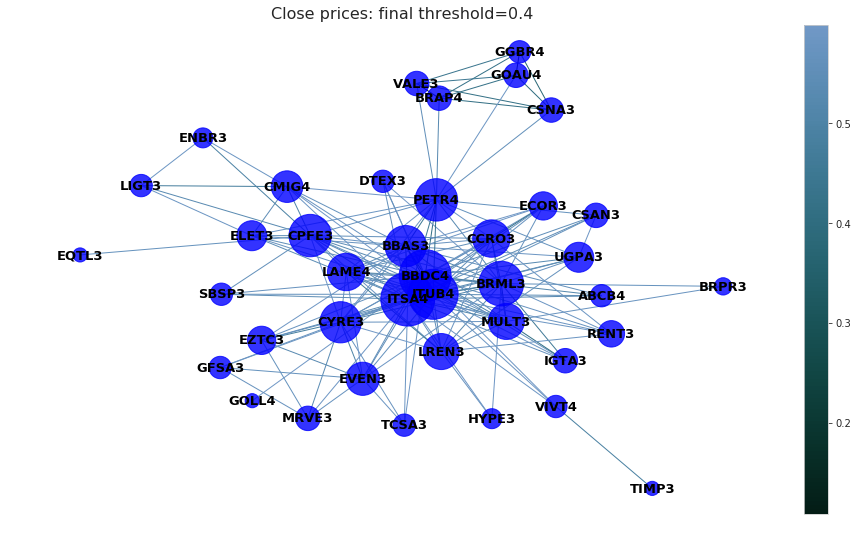

In [26]:
# plots the distance correlation network of the daily opening prices from 2006-2014
plt_corr_nx(H_close, title='Close prices: final threshold=0.4')

In the above visualization, the sizes of the vertices are proportional to the number of connections they have. The colorbar to the right indicates the degree of disimilarity (the distance) between the stocks. The larger the value (the lighter the color) the less similar the stocks are. Keeping this in mind, several stocks jump out. **JBS**, **CSMG**, **HBOR3**, and all the ones that lie on the periphery of the network with the fewest number of correlations above $\rho_{c} = 0.325$. On the other hand **BBAS3**, **ITUB4**, **BBDC4**, and **LAME4** sit in the core of the network with the greatest number connections above $\rho_{c} = 0.325$. It is clear from the closing prices network that our asset allocation algorithm needs to reward vertices on the periphery and punish those nearing the center. In the next code block we build a function to visualize how the edges of the distance correlation network are distributed.

## Degree Histogram

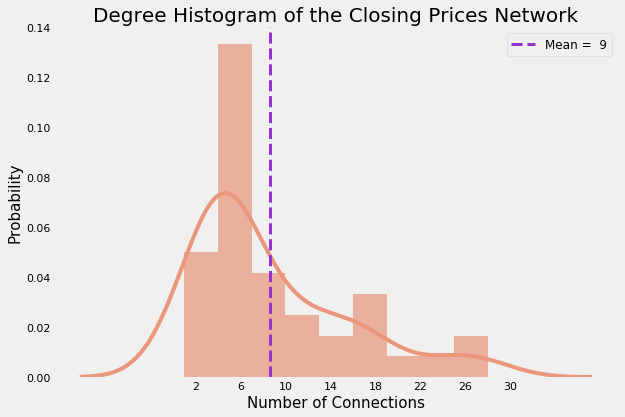

In [27]:
# plots the degree histogram of the closing prices network
hist_plot(
    H_close, 
    'Degree Histogram of the Closing Prices Network', 
    bins=9, 
    xticks=range(2, 31, 4)
)

# Communicability as a Measure of Relative Risk

We are now in a position to devise a method to compute the allocation weights of our portfolio. To recall, this is the problem:

**Given the $N$ assets in our portfolio, find a way of computing the allocation weights $w_{i}$, &thinsp; $\Big( \sum_{i=1}^{N}w_{i}=1\Big)$ such that assets more correlated with each other obtain lower weights while those less correlated with each other obtain higher weights.**

Theres an infinite number of possible solutions to the above problem. The asset correlation network we built contains information on how our portfolio is interrelated (whose connected to who), but it does not tell us how each asset *impacts* the other or how those impacts travel throughout the network. If, for example, Apple's stock lost 40% of its value wiping out, say, two years of gains, how would this impact the remaining assets in our portfolio? How easily does this kind of behaviour spread and how can we keep our capital isolated from it? We thus seek a measure of "relative risk" that quantifies not only the correlations between assets, but how those correlations mediate perturbations in the portfolio. Our aim, therefore, is twofold: allocate capital inversely proportional to (1) the correlations between assets and (2) proportional to the "impact resistence" of each asset. As luck would have it, there is a [centrality](https://en.wikipedia.org/wiki/Centrality) measure that does just this! Let us define the relative risk as follows:

<br/><br/>
<center>$\text{Relative Risk of Asset} \ r$ = $\dfrac{\omega_{r}}{\sum_{r'=1}^{N}\omega_{r'}}$,</center>
<br/><br/>
where 
<center>$\omega_{r} = \dfrac{1}{C}\sum_{p}\sum_{q}\dfrac{G_{prq}}{G_{pq}}$</center>

is the **Communicability Betweenness centrality** [(Estrada, *et al.* (2009))](https://arxiv.org/pdf/0905.4102.pdf) of node $r$. Here
<br/><br/>
<center>$G_{prq} = \big(\exp{\textbf{A}}\big)_{pq} - \big(\exp{(\textbf{A} - \textbf{E}(r))}\big)_{pq}$</center>

is the number of weighted [walks](http://mathworld.wolfram.com/Walk.html) involving only node $r$,
<br/><br/>
<center>$G_{pq} = \big(\exp{\textbf{A}}\big)_{pq}$</center>

is the so-called *communicability* between nodes $p$ and $q$,
<br/><br/>
<center>$A_{pq} = \begin{cases} 
      1, & \text{if} \ \rho \geq \rho_{c}  \\
      0, & \text{otherwise}
   \end{cases}$</center>
   
is the adjacency matrix induced by the distance correlation matrix $\text{Cor}_{ij}$, and $\textbf{E}(r)$ is a matrix such that when added to $\textbf{A}$, yields a new graph $G(r) = (V, E')$ with all edges connecting $r \in V$ removed. The constant $C = (n-1)^2 - (n-1)$ normalizes $\omega_{r}$ such that it takes values between 0 and 1. We can better understand what $\omega_{r}$ is counting by re-writing the matrix exponential as a taylor series:
<br/><br/>

<center>$\exp{\textbf{A} = \sum_{k=1}^{\infty}}\dfrac{\textbf{A}^{k}}{k!}$</center>

Rasing the adjacency matrix to the power of $k$ counts all walks from $p$ to $q$ of length $k$. The matrix exponential therefore counts all possible ways of moving from $p$ to $q$ weighted by the inverse factorial of $k$. So the denominator of $\omega_{r}$ counts all weighted walks involving every node. Put simply,
<br/><br/>

<center>$\boxed{\text{Communicability Betweenees centrality} = \dfrac{\text{sum of all weighted walks involving node r}}{\text{sum of all weighted walks involving every node}}}$</center>

So the communicability betweenness centrality is proportional to the number of connections (correlations) a node has and therefore satisifies the first requirement of relative risk. Next, we explore how this measure quantifies the spread of impacts throughout the network, satisfying our second requirement.

## The Physics of what Communicability Measures

[Estrada & Hatano (2007)](https://arxiv.org/pdf/0707.0756.pdf) provided an ingenius argument showing the communicability of a network is identical to the Green's function of a network. That is, it measures how impacts (or more generally thermal fluctuations) travel from one node to another. Their argument works by treating each node as an oscillator and each edge as a spring (which is what we did to generate the visualization of our asset correlation network). Intuitively, we can draw an analogy between the movement of an asset's price and its motion in a ball-spring system. In this analogy, volatility is equivalent to how energetic the oscillator is. Revisiting the hypothetical scenerio of Apple losing 40% of its value: we can visualize this in our mind's eye as an impact to one of the masses---causing it to violently oscillate. How does this motion propagate throughout the rest of the ball-spring system? Which masses absorb the blow and which reflect it? Communicability betweeness centrality answers this question by counting all possible ways the impact can reach node $r$. Higher values indicate the node has a greater susceptiblility to impacts whereas lower values denote just the opposite.

# The Bottom Line

The communicability of a network quantifies how impacts spread from one node to another. In the context of an asset correlation network, communicability measures how volatility travels node to node. **We aim to position our capital such that it's the most resistant to the communicability of volatility**. Recall we seek a portfolio that (1) consistently generates wealth while minimizing potential losess and (2) is robust against large market fluctuations and economic downturns. Of course, generous returns are desired, but not in a way that threatens our initial investment. To this end, the strategy moving forward is this: allocate capital inversely proportional to its relative (or intraportfolio) risk.


## Intraportfolio Risk

In [28]:
zero_degree = []
nonzero_degree = []
for t, d in H_close.degree():
    if d == 0:
        zero_degree.append(t)
    else:
        nonzero_degree.append(t)
        
print(zero_degree)
print(len(zero_degree))
print(nonzero_degree)
print(len(nonzero_degree))

[]
0
['ABCB4', 'BBAS3', 'BBDC4', 'BRAP4', 'BRML3', 'BRPR3', 'CCRO3', 'CMIG4', 'CPFE3', 'CSAN3', 'CSNA3', 'CYRE3', 'DTEX3', 'ECOR3', 'ELET3', 'ENBR3', 'EQTL3', 'EVEN3', 'EZTC3', 'GFSA3', 'GGBR4', 'GOAU4', 'GOLL4', 'HYPE3', 'IGTA3', 'ITSA4', 'ITUB4', 'LAME4', 'LIGT3', 'LREN3', 'MRVE3', 'MULT3', 'PETR4', 'RENT3', 'SBSP3', 'TCSA3', 'TIMP3', 'UGPA3', 'VALE3', 'VIVT4']
40


In [29]:
len(zero_degree)

0

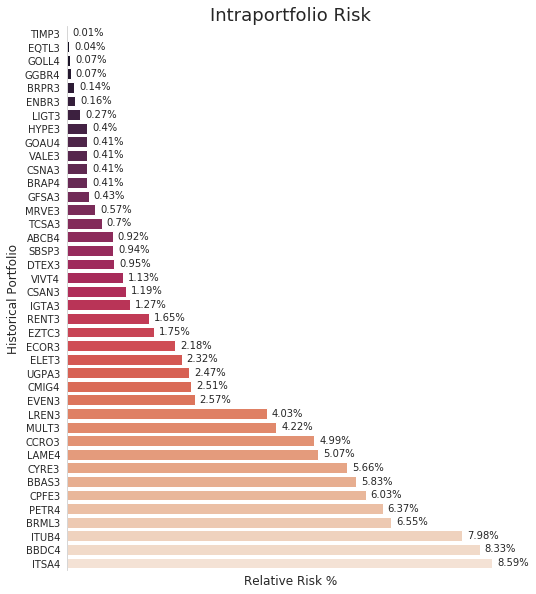

In [30]:
# calculates the communicability betweeness centrality and returns a dictionary
risk_alloc = nx.communicability_betweenness_centrality(H_close)
#risk_alloc = nx.eigenvector_centrality(H_master)
# print(risk_alloc)
# converts the dictionary of degree centralities to a pandas series
risk_alloc = pd.Series(risk_alloc)

# normalizes the degree centrality 
risk_alloc = risk_alloc / risk_alloc.sum()

# resets the index
risk_alloc.reset_index()

# converts series to a sorted DataFrame
risk_alloc = (
    pd.DataFrame({"Stocks": risk_alloc.index, "Risk Allocation": risk_alloc.values})
        .sort_values(by="Risk Allocation", ascending=True)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    # initializes figure
    plt.figure(figsize=(8,10))

    # plots a pretty seaborn barplot
    sns.barplot(x='Risk Allocation', y='Stocks', data=risk_alloc, palette="rocket")

    # removes spines
    sns.despine(right=True, top=True, bottom=True)

    # turns xticks off
    plt.xticks([])

    # labels the x axis
    plt.xlabel("Relative Risk %", size=12)

    # labels the y axis
    plt.ylabel("Historical Portfolio", size=12)

    # figure title
    plt.title("Intraportfolio Risk", size=18)

    # iterates over the stocks (label) and their numerical index (i)
    for i, label in enumerate(list(risk_alloc.index)):

        # gets the height of each bar in the barplot
        height = risk_alloc.loc[label, 'Risk Allocation']

        # gets the relative risk as a percentage (the labels)
        label = (risk_alloc.loc[label, 'Risk Allocation']*100 
                    ).round(2).astype(str) + '%'

        # annotates the barplot with the relative risk percentages
        plt.annotate(str(label), (height + 0.001, i + 0.15))

In [31]:
# Helper to get company names
df.loc[df.Ticker == "ITSA4"].Name.iloc[0]

'ITAUSA'

We read an intraportfolio risk plot like this: VALE3 (*Companhia Vale do Rio Doce*) is $\dfrac{0.41}{0.07} = 5.86$ times riskier than GGBR4 (*Gerday*), BBDC4 (*Banco Bradesco*) is $\dfrac{8.33}{1.65} = 5.05$ times riskier than RENT3 (Localiza), ... , and ITSA4 (Itaú S.A.) is $\dfrac{8.59}{0.16} = 53.69$ times more risky than EMBR3 (Embraer)! 

Intuitively, the assets that cluster in the center of the network are most susceptible to impacts, whereas those further from the cluster are the least susceptible. The logic from here is straightforward: take the inverse of the relative risk (which we call the "relative certainty") and normalize it such that it adds to 1. These are the asset weights. Formally,
<br/><br/>
<center>$\text{w}_{r} = \dfrac{1}{\omega_{r} \sum_{r'}\omega_{r'}^{-1}}$</center>

Next, Let's visualize the allocation of 10,000 (USD) in our portfolio.

## Communicability-Based Asset Allocation

In [32]:
# calculates degree centrality and assigns it to investmnet_A
investment_A = nx.communicability_betweenness_centrality(H_close)
#investment_A = nx.eigenvector_centrality(H_close)

# calculates the inverse of the above and re-asigns it to investment_A as a pandas series
investment_A = 1 / pd.Series(investment_A)

# normalizes the above
investment_A = investment_A / investment_A.sum()
investment_A

ABCB4    0.003991
BBAS3    0.000630
BBDC4    0.000441
BRAP4    0.009008
BRML3    0.000561
BRPR3    0.026876
CCRO3    0.000736
CMIG4    0.001465
CPFE3    0.000609
CSAN3    0.003081
CSNA3    0.009008
CYRE3    0.000650
DTEX3    0.003854
ECOR3    0.001683
ELET3    0.001588
ENBR3    0.023474
EQTL3    0.093438
EVEN3    0.001428
EZTC3    0.002099
GFSA3    0.008530
GGBR4    0.052519
GOAU4    0.009008
GOLL4    0.055231
HYPE3    0.009154
IGTA3    0.002894
ITSA4    0.000428
ITUB4    0.000461
LAME4    0.000726
LIGT3    0.013704
LREN3    0.000912
MRVE3    0.006452
MULT3    0.000870
PETR4    0.000577
RENT3    0.002228
SBSP3    0.003931
TCSA3    0.005241
TIMP3    0.628771
UGPA3    0.001488
VALE3    0.009008
VIVT4    0.003249
dtype: float64

In [34]:
def softmax_temp(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    # preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return preds


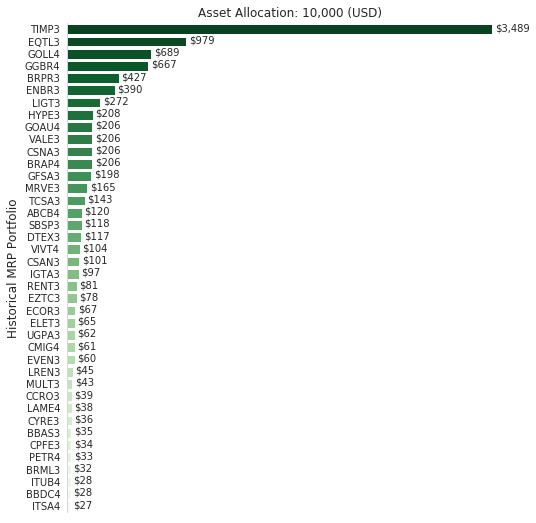

In [35]:
# calculates degree centrality and assigns it to investmnet_A
investment_A = nx.communicability_betweenness_centrality(H_close)
#investment_A = nx.eigenvector_centrality(H_close)

# calculates the inverse of the above and re-asigns it to investment_A as a pandas series
investment_A = 1 / pd.Series(investment_A)

# normalizes the above
investment_A = softmax_temp(investment_A, 1.5)# np.exp(investment_A) / np.exp(investment_A).sum()#investment_A / investment_A.sum()

# resets the index
#investment_A.reset_index()

# converts the above series to a sorted DataFrame
investment_A = (
    pd.DataFrame({"Stocks": investment_A.index, "Asset Allocation": investment_A.values})
        .sort_values(by="Asset Allocation", ascending=False)
        .reset_index()
        .drop("index", axis=1)
)

with sns.axes_style('whitegrid'):
    # initializes a figure
    plt.figure(figsize=(8,9))

    # plot a pretty seaborn barplot
    sns.barplot(x='Asset Allocation', y='Stocks', data=investment_A, palette="Greens_r")

    # despines the figure
    sns.despine(right=True, top=True, bottom=True)

    # turns xticks off
    plt.xticks([])

    # turns the x axis label off
    plt.xlabel('')

    # fig title
    plt.title("Asset Allocation: 10,000 (USD)", size=12)

    # y axis label
    plt.ylabel("Historical MRP Portfolio", size=12)

    # captial to be allocated
    capital = 10000

    # iterates over the stocks (label) and their numerical indices (i)
    for i, label in enumerate(list(investment_A.index)):

        # gets the height of each bar
        height = investment_A.loc[label, 'Asset Allocation']

        # calculates the capital to be allocated
        label = (investment_A.loc[label, 'Asset Allocation'] * capital
                    ).round(2)

        # annotes the capital above each bar
        plt.annotate('${:,.0f}'.format(label), (height + 0.002, i + 0.15))

In [36]:
investment_A.iloc[:, 1].cumsum()

0     0.348924
1     0.446817
2     0.515766
3     0.582438
4     0.625093
5     0.664069
6     0.691294
7     0.712097
8     0.732680
9     0.753263
10    0.773845
11    0.794428
12    0.814276
13    0.830753
14    0.845098
15    0.857060
16    0.868901
17    0.880586
18    0.891014
19    0.901081
20    0.910735
21    0.918843
22    0.926637
23    0.933363
24    0.939833
25    0.946028
26    0.952160
27    0.958188
28    0.962658
29    0.966991
30    0.970867
31    0.974706
32    0.978272
33    0.981767
34    0.985183
35    0.988477
36    0.991711
37    0.994547
38    0.997301
39    1.000000
Name: Asset Allocation, dtype: float64

In [37]:
investment_A.iloc[:10]

,Stocks,Asset Allocation
0,TIMP3,0.348924
1,EQTL3,0.097893
2,GOLL4,0.068949
3,GGBR4,0.066672
4,BRPR3,0.042655
5,ENBR3,0.038976
6,LIGT3,0.027225
7,HYPE3,0.020803
8,GOAU4,0.020583
9,VALE3,0.020583


In [38]:
investment_A.tail()

,Stocks,Asset Allocation
35,PETR4,0.003294
36,BRML3,0.003235
37,ITUB4,0.002835
38,BBDC4,0.002754
39,ITSA4,0.002699


It's worth pointing out that the methods we've used to generate the asset allocation weights differ dramatically from the contemporary methods of MPT and its extensions. The approach taken in this project makes no assumptions of future outcomes of a portfolio, i.e., the algorithm doesn't require us to make a prediction of the expected returns (as MPT does). What's more---we're not solving an optimization problem---there's nothing to be minimized or maximized. Instead, we observe the topology (interrelatedness) of our portfolio, predict which assets are the most susceptible to the communicability of volatile behaviour and allocate capital accordingly.

In [39]:
df_train_close_copy.index.max()

'2016-12-29'

In [40]:
# DataFrame of the prices we buy stock at
df_buy_in = df_train_close_copy.loc[TRAIN_RANGE[1]].sort_index().to_frame('Buy In: {}'.format(TRAIN_RANGE[1]))
df_buy_in

,Buy In: 2016-12-29
Ticker,
ABCB4,13.93
BBAS3,28.09
BBDC4,29.00
BRAP4,14.85
BRML3,11.95
BRPR3,7.50
CCRO3,15.96
CMIG4,7.71
CPFE3,25.21


## Alternative Allocation Strategy: Allocate Capital in the Maximum Independent Set

The maximum independent set (MIS) is the largest set of vertices such that no two are adjacent. Applied to our asset correlation network, the MIS is the greatest number of assets such that every pair has a correlation below $\rho_{c}$. The size of the MIS is inversely proportional to the threshold $\rho_{c}$. Larger values of $\rho_{c}$ produce a sparse network (more edges are removed) and therefore the MIS tends to be larger. An optimized portfolio would therefore correspond to maximizing the size of the MIS subject to minimizing $\rho_{c}$. The best way to do this is to increase the universe of assets we're willing to invest in. By further diversifying the portfolio with many asset types and classes, we can isolate the largest number of minimally correlated assets and allocate capital inversely proportional to their relative risk. While generating the asset weights remains a non-optimization problem, generating the asset correlation network *becomes* one. We're really solving two sepreate problems: determing how to build the asset correlation network (there are many) and determining which graph invariants (there are many) extract the asset weights from the network. As such, one can easily imagine a vast landscape of portfolios beyond that of MPT and a metric fuck-tonne of wealth to create. **Unfortunately, solving the MIS problem is NP-hard. The best we can do is find an approximation.**

## Using Expert Knowledge to Approximate the Maximum Independent Set

We have two options: randomly generate a list of maximal indpendent sets (subgraphs of $G$ such that no two vertices share an edge) and select the largest one, or use expert knowledge to reduce the number of sets to generate and do the latter. Both methods are imperfect, but the former is far more computationally expensive than the latter. Suppose we do fundamentals research and conclude ITUB4 must be in our portfolio. How could we imbue the algorithm with this knowledge? Can we make the algorithm flexible enough for portfolio managers to fine-tune with goold-ole' fashioned research, while at the same time keeping it rigged enough to prevent poor decisions from producing terribe portfolios? We confront this problem in the code block below by extracting an approximate MIS by generating 100 random maximal indpendent sets containing ITUB4.

In [41]:
# a function to generate a random approximate MIS
### WARNING: rerunning kernel will produce different MISs
from header import generate_mis

In [42]:
max_ind_set = generate_mis(H_close, sample_size=500)
print(max_ind_set)

['ELET3', 'BRPR3', 'GFSA3', 'CSAN3', 'EZTC3', 'IGTA3', 'GGBR4', 'LAME4', 'EQTL3', 'ENBR3', 'GOLL4', 'HYPE3', 'TIMP3', 'DTEX3', 'TCSA3', 'ABCB4', 'RENT3', 'SBSP3']


The ```generate_mis``` function generates a maximal independent set that approximates the true maximum independent set. As an option, the user can pick a list of assets they want in their portfolio and ```generate_mis``` will return the safest assets to complement the user's choice. Picking UNH and AMZN left us with VZ and MCD. The weights of these assets will remain directly inversely proportional to the communicability betweeness centrality.

In [43]:
# prices of shares to buy for the MIS
df_mis_buy_in = df_buy_in.loc[list(max_ind_set)]
df_mis_buy_in

,Buy In: 2016-12-29
Ticker,
ELET3,22.81
BRPR3,7.50
GFSA3,1.86
CSAN3,38.15
EZTC3,15.65
IGTA3,26.67
GGBR4,10.80
LAME4,17.00
EQTL3,54.40


# Backtesting with Modern Portfolio Theory

Now that we have a viable alternative to portfolio optimization, it's time to see how the Hedgecraft portfolio performed in the validation years (15', 16', and 17') with respect to the Markowitz portfolio (i.e., the [efficient frontier](https://www.investopedia.com/video/play/explaining-efficient-frontier/) model) and the overall market. To summarize our workflow thus far we:

1. Preprocessed historical pricing data of 31 stocks for time series analyses.
2. Computed the distance correlation matrix $\rho_{D}(X_{i}, X_{j})$ for the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` from 2006-2014.
3. Used the NetworkX module to transform each distance correlation matrix into a weighted graph.
4. Adopted the winner-take-all method by Tse, et al. and removed edges with correlations below a threshold value of $\rho_{c} = 0.325$.
5. Built a master network by averaging over the edge weights of the ``Open``, ``High``, ``Low``, ``Close``, and ``Close_diff`` networks.
6. Calculated the "relative risk" of each asset as the communicabality betweeness centrality assigned to each node.
7. Generated the asset weights as the normalized inverse of communicability betweeness centrality.

In addition to the above steps, we introduced a human-in-the-middle strategy, giving the user flexible control over the portfolio construction process. This is the extra step we added:

8. Adjust the asset weights for an approximate maximum independent set, either with or without human intervention.

To distinguish bewteen these two approaches we designate steps 1-7 as the *Hedgecraft* algo and steps 1-8 as the *Hedgecraft MIS* algo. Below we observe how these models perform with the Efficient Frontier as a benchmark.

## Generating Hedgecraft Portfolio Weights

In [44]:
# calculates communicability betweeness centrality
weights = nx.communicability_betweenness_centrality(H_close)
#weights = nx.eigenvector_centrality(H_master)

# dictionary comprehension of communicability centrality for the maximum independent set
mis_weights = {key: weights[key] for key in list(max_ind_set)}


# a function to convert centrality scores to portfolio weights
from header import centrality_to_portfolio_weights

print(centrality_to_portfolio_weights(weights))
print('\n')
print(centrality_to_portfolio_weights(mis_weights))

{'ABCB4': 0.004, 'BBAS3': 0.001, 'BBDC4': 0.0, 'BRAP4': 0.009, 'BRML3': 0.001, 'BRPR3': 0.027, 'CCRO3': 0.001, 'CMIG4': 0.001, 'CPFE3': 0.001, 'CSAN3': 0.003, 'CSNA3': 0.009, 'CYRE3': 0.001, 'DTEX3': 0.004, 'ECOR3': 0.002, 'ELET3': 0.002, 'ENBR3': 0.023, 'EQTL3': 0.093, 'EVEN3': 0.001, 'EZTC3': 0.002, 'GFSA3': 0.009, 'GGBR4': 0.053, 'GOAU4': 0.009, 'GOLL4': 0.055, 'HYPE3': 0.009, 'IGTA3': 0.003, 'ITSA4': 0.0, 'ITUB4': 0.0, 'LAME4': 0.001, 'LIGT3': 0.014, 'LREN3': 0.001, 'MRVE3': 0.006, 'MULT3': 0.001, 'PETR4': 0.001, 'RENT3': 0.002, 'SBSP3': 0.004, 'TCSA3': 0.005, 'TIMP3': 0.629, 'UGPA3': 0.001, 'VALE3': 0.009, 'VIVT4': 0.003}


{'ELET3': 0.002, 'BRPR3': 0.029, 'GFSA3': 0.009, 'CSAN3': 0.003, 'EZTC3': 0.002, 'IGTA3': 0.003, 'GGBR4': 0.057, 'LAME4': 0.001, 'EQTL3': 0.101, 'ENBR3': 0.025, 'GOLL4': 0.06, 'HYPE3': 0.01, 'TIMP3': 0.678, 'DTEX3': 0.004, 'TCSA3': 0.006, 'ABCB4': 0.004, 'RENT3': 0.002, 'SBSP3': 0.004}


Hedgecraft MIS allocates a staggering 91.4% of the investment to UNH. At first sight this portfolio appears far less diversified than Hedgecraft. However, if we recall, the relative risk of UNH was two orders of magnitude smaller than **every** other security (with the sole exception of Altaba). If our only options are the above 31 securities, the algorithm predicts UNH is the safest pick and allocates accordingly.

## Allocating Shares to the Hedgecraft Portfolio

In [ ]:
# !pip install pyportfolioopt

In [45]:
# imports a tool to convert capital into shares
from pypfopt import discrete_allocation

# returns the number of shares to buy given the asset weights, prices, and capital to invest
alloc = discrete_allocation.DiscreteAllocation(
    weights, 
    df_buy_in['Buy In: {}'.format(TRAIN_RANGE[1])],
    total_portfolio_value=capital
)

# returns same as above but for the MIS
mis_alloc = discrete_allocation.DiscreteAllocation(
    mis_weights, 
    df_mis_buy_in['Buy In: {}'.format(TRAIN_RANGE[1])],
    total_portfolio_value=capital
)

33 out of 40 tickers were removed
12 out of 18 tickers were removed


In [46]:
alloc = alloc.greedy_portfolio()[0]

mis_alloc = mis_alloc.greedy_portfolio()[0]

In [47]:
# converts above shares to a pandas series
alloc_series = pd.Series(alloc, name='Shares')

# names the series
alloc_series.index.name = 'Assets'

# resets index, prints assets with the shares we buy
alloc_series.reset_index
print(alloc_series)

print('\n')

# does same as above but for the MIS
mis_alloc_series = pd.Series(mis_alloc, name='MIS Shares')
mis_alloc_series.index.name = 'Assets'
mis_alloc_series.reset_index
print(mis_alloc_series)

Assets
TIMP3    803
EQTL3     17
GOLL4    119
GGBR4     49
BRPR3     36
ENBR3     17
LIGT3      8
Name: Shares, dtype: int64


Assets
TIMP3    865
EQTL3     18
GOLL4    129
GGBR4     52
BRPR3     38
ENBR3     18
Name: MIS Shares, dtype: int64


In [48]:
# converts Hedgecraft shares series to a DataFrame
df_alloc = alloc_series.sort_index().to_frame('Shares')

# converts Hedgecraft MIS shares series to a DataFrame
df_mis_alloc = mis_alloc_series.sort_index().to_frame('MIS Shares')

In [49]:
df_mis_alloc.to_csv("data/mis_alloc.csv")
df_alloc.to_csv("data/mrp_alloc.csv")

##  The Efficient Frontier

Harry Markowitz's 1952 paper [Portfolio Selection](https://www.math.ust.hk/~maykwok/courses/ma362/07F/markowitz_JF.pdf) transformed portfolio management from an art to a science. Markowitz's key insight came from diversification: by combinining uncorrelated assets with different expected returns and volatilities, one can calculate an optimal allocation.

The main idea is this: if $w$ is the fraction of capital to be allocated to some asset, then the portfolio risk in terms of the covariance matrix $\Sigma$ is given by $w^{\top}\Sigma w$ and its expected returns are given by $w^{\top}\mu$. The optimal portfolio can therefore be regarded as a convex optimization problem, and a solution can be found with quadratic programming. Denoting the target returns as $\mu*$ the optimization problem is mathmeatically expressed as follows:
<br/><br/>
<center>\begin{split}\begin{equation*}
\begin{aligned}
& \underset{w}{\text{minimise}} & & w^T \Sigma w \\
& \text{subject to} & & w^T\mu \geq \mu^*\\
&&& w^T\mathbf{1} = 1 \\
&&& w_i \geq 0 \\
\end{aligned}
\end{equation*}\end{split}</center>

Varying the target return yields a different set of weights (i.e., a different portfolio). The set of all the portfolios with optimal weights is referred to as the **efficient frontier**.

![](https://pyportfolioopt.readthedocs.io/en/latest/_images/efficient_frontier.png)

Each dot in the above plot represents a different possible portoflio, with darker blue corresponding to better portfolios (in terms of the Sharpe ratio). The dotted black line is the frontier. The triangular markers denote the optimal portfolios subjected to different optimization objectives.

In the code blocks bellow we use the PyPortfolioOpt library to implement the Efficient Frontier algorithm. Rather than optimizing for a maximum Sharpe ratio, we optimize for a minimum volatility as these portfolios tend to outperform portfolio's with a maximized Sharpe ratio.

In [50]:
# imports a tool to calculate the mean historical return from a 
# portfolio optimization package called pypfopt
from pypfopt.expected_returns import mean_historical_return

# returns the mean historical return of the training data
mu = mean_historical_return(df.pivot(columns='Ticker', values='Close').dropna())

# computes the covariance matrix
S = df.pivot(columns='Ticker', values='Close').dropna().cov()

In [51]:
# imports the efficient frontier model for asset allocation
from pypfopt.efficient_frontier import EfficientFrontier

# runs the efficient frontier (EF) algo
ef = EfficientFrontier(mu, S)

# computes portfolio weights subject to minimizing the volatility (portfolio std)
weights_ef = ef.min_volatility()

# rounds and prints the weights
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

{'ABCB4': 0.0, 'BBAS3': 0.0, 'BBDC4': 0.0, 'BRAP4': 0.0, 'BRML3': 0.0, 'BRPR3': 0.0, 'CCRO3': 0.0, 'CMIG4': 0.0, 'CPFE3': 0.0, 'CSAN3': 0.0, 'CSNA3': 0.0, 'CYRE3': 0.0, 'DTEX3': 0.0, 'ECOR3': 0.0, 'ELET3': 0.0, 'ENBR3': 0.16285, 'EQTL3': 0.01771, 'EVEN3': 0.0, 'EZTC3': 0.0, 'GFSA3': 0.0, 'GGBR4': 0.0, 'GOAU4': 0.0, 'GOLL4': 0.0, 'HYPE3': 0.0, 'IGTA3': 0.0, 'ITSA4': 0.01722, 'ITUB4': 0.0, 'LAME4': 0.16042, 'LIGT3': 0.0, 'LREN3': 0.0, 'MRVE3': 0.0, 'MULT3': 0.0, 'PETR4': 0.0, 'RENT3': 0.0, 'SBSP3': 0.0, 'TCSA3': 0.40081, 'TIMP3': 0.20682, 'UGPA3': 0.03417, 'VALE3': 0.0, 'VIVT4': 0.0}


## Allocating Shares to the Markowitz Portfolio

In [52]:
# returns the number of shares to buy given asset prices, weights, and capital to invest for the EF model
ef_alloc = discrete_allocation.DiscreteAllocation(
    weights_ef,
    df_buy_in['Buy In: {}'.format(TRAIN_RANGE[1])],
    total_portfolio_value=capital
)

33 out of 40 tickers were removed


In [53]:
ef_alloc = ef_alloc.greedy_portfolio()[0]

In [54]:
# converts EF shares to a pandas series
ef_alloc_series = pd.Series(ef_alloc, name='Shares')

# names the series
ef_alloc_series.index.name = 'Assets'

# resets index, prints assets and the shares we buy
ef_alloc_series.reset_index

<bound method Series.reset_index of Assets
TCSA3    1855
TIMP3     264
ENBR3     122
LAME4      94
UGPA3       5
EQTL3       3
ITSA4      21
Name: Shares, dtype: int64>

The Efficient Frontier produces a radically different portfolio than Hedgecraft or its MIS variant.

In [55]:
# converts EF shares series to a DataFrame
df_ef_alloc = ef_alloc_series.sort_index().to_frame('Shares')
df_ef_alloc

,Shares
Assets,
ENBR3,122
EQTL3,3
ITSA4,21
LAME4,94
TCSA3,1855
TIMP3,264
UGPA3,5


In [158]:
df_ef_alloc.to_csv("data/ef_alloc.csv")

# Portfolio Performance: Hedgecraft vs. Efficient Frontier

In this section we write production (almost) ready code for portfolio analysis and include our own risk-adjusted returns score. The section looks something like this:

* We obtain the cumulative returns and returns on investment,
* extract the end of year returns and annual return rates,
* calculate the average annual rate of returns and annualized portfolio standard deviation,
* compute the Sharpe Ratio, 
* Maximum Drawdown, 
* Returns over Maximum Drawdown, 
* and our own unique measure: the Growth-Risk Ratio.

Finally, we visualize the returns, drawdowns, and returns distribution of each model and analyze the results.

In [56]:
# total capital invested in the Hedgecraft portfolio after buying shares
capital = (df_buy_in['Buy In: {}'.format(TRAIN_RANGE[1])]*df_alloc['Shares']).sum()

# total capital invested in Efficient Frontier portfolio after buying shares
ef_capital = (df_buy_in['Buy In: {}'.format(TRAIN_RANGE[1])]*df_ef_alloc['Shares']).sum()

# total capital invested in Hedgecraft MIS portfolio after buying shares
mis_capital = (df_mis_buy_in['Buy In: {}'.format(TRAIN_RANGE[1])]*df_mis_alloc['MIS Shares']).sum()


# function to compute the cumulative returns of a portfolio
from header import cumulative_returns

# Hedgecraft cumulative daily returns
total_daily_returns = cumulative_returns(
    df_alloc, 
    capital, 
    df_validate
).rename('MRP Cumulative Daily Returns')


# Efficient Frontier cumulative daily returns
ef_total_daily_returns = cumulative_returns(
    df_ef_alloc, 
    ef_capital, 
    df_validate
).rename('EF Cumulative Daily Returns')


# Hedgecraft MIS cumulative daily returns
mis_total_daily_returns = cumulative_returns(
    df_mis_alloc, 
    mis_capital, 
    df_validate
).rename('MIS Cumulative Daily Returns')

# function to compute daily return on investment (roi)
from header import portfolio_daily_roi

# Hedgecraft daily return on investment
daily_roi = portfolio_daily_roi(
    df_alloc, 
    capital, 
    df_validate
).rename('MRP Daily Returns')


# Efficient Frontier daily return on investment
ef_daily_roi = portfolio_daily_roi(
    df_ef_alloc, 
    ef_capital, 
    df_validate
).rename('EF Daily Returns')


# Hedgecraft MIS daily return on investment
mis_daily_roi = portfolio_daily_roi(
    df_mis_alloc, 
    mis_capital, 
    df_validate
).rename('MIS Daily Returns')


In [57]:
print(capital)
print(mis_capital)
print(ef_capital)

8927.949999999999
9435.93
9986.05


# End of Year Returns

In [58]:
# imports datetime manipluation library
from datetime import datetime

# function to extract the end of year returns
from header import end_of_year_returns

# Hedgecraft annual return rates     
returns_dict = end_of_year_returns(
    daily_roi, 
    'return_rates', 
    int(TEST_RANGE[0][:4]),
    int(TEST_RANGE[1][:4])
)

# Efficient Frontier annual return rates
ef_returns_dict = end_of_year_returns(
    ef_daily_roi, 
    'return_rates', 
    int(TEST_RANGE[0][:4]),
    int(TEST_RANGE[1][:4])
)

# Hedgecraft MIS annual return rates
mis_returns_dict = end_of_year_returns(
    mis_daily_roi, 
    'return_rates', 
    int(TEST_RANGE[0][:4]),
    int(TEST_RANGE[1][:4])
)

# Hedgecraft annual returns
tot_returns_dict = end_of_year_returns(
    daily_roi, 
    'returns', 
    int(TEST_RANGE[0][:4]),
    int(TEST_RANGE[1][:4])
)

# Efficient Frontier annual returns
ef_tot_returns_dict = end_of_year_returns(
    ef_daily_roi, 
    'returns', 
    int(TEST_RANGE[0][:4]),
    int(TEST_RANGE[1][:4])
)

# Hedgecraft MIS annual returns
mis_tot_returns_dict = end_of_year_returns(
    mis_daily_roi, 
    'returns', 
    int(TEST_RANGE[0][:4]),
    int(TEST_RANGE[1][:4])
)

# Average Annual Rate of Returns

In [59]:
# function to calculate avg annual portfolio returns
from header import avg_annual_returns

# Hedgecraft avg annual returns    
gmean_returns = avg_annual_returns(returns_dict, mstat='geometric')

# Efficient Frontier avg annual returns
ef_gmean_returns = avg_annual_returns(ef_returns_dict, mstat='geometric')

# Hedgecraft MIS avg annual returns
mis_gmean_returns = avg_annual_returns(mis_returns_dict, mstat='geometric')

print(gmean_returns)
print(ef_gmean_returns)
print(mis_gmean_returns)

0.74
-2.39
0.86


In [60]:
mis_returns_dict

{'2017': 66.3, '2018': 5.2, '2019': 47.9, '2020': -60.0}

# Annualized Portfolio Standard Deviation

The annualized standard deviation (a.k.a volatility) measures how far the portfolio's returns vary from the mean, that is, it measures how spread out the data is. It can be readily calculated as:

$\sigma = \sqrt{252 \cdot \textbf{w}^{\top}\mathbf{\Sigma} \textbf{w}}$

where $252$ is the number of trading days in a year, $\textbf{w}$ is the vector of portfolio weights, and $\mathbf{\Sigma}$ is the covariance matrix.

# Annualized Sharpe Ratio

The Sharpe ratio is one of the most popular measures of risk-adjusted returns. It measures the excess of mean returns per unit deviation of the returns. The annualized Sharpe Ratio is given by,
<br/><br/>
<center>$ S = \dfrac{\bar{R} - \bar{R}_{f}}{\sigma} $</center>

where $\bar{R}$ is the average annual rate of returns, $\bar{R}_{f}$ is the average risk-free rate for the duration of the investment (usually taken as the 10-year treasurey rate), and $\sigma$ is the annualized standard deviation. A Sharpe ratio greater than one usually signifies a portfolio of superior performance as opposed to a portfolio with a Sharpe ratio less than one. In general, a portfolio with a larger Sharpe ratio will outperform one with a smaller ratio. A snazzy article summarizing the use of the Sharpe ratio is given [here](https://www.investopedia.com/terms/s/sharperatio.asp).

In [62]:
# function to calculate annualized portoflio standard deviation
from header import portfolio_std
# function to calculate annualized portfolio standard deviation with a
# maximum independent set parameter
from header import mis_portfolio_std

# Hedgecraft annualized volatility
portfolio_std_dev = portfolio_std(
    weights=weights, 
    test_data=df_validate
)

# Efficient Frontier annualized volatility
ef_portfolio_std_dev = portfolio_std(
    weights=weights_ef, 
    test_data=df_validate
)

# Hedgecraft MIS annualized volatility
mis_portfolio_std_dev = mis_portfolio_std(
    weights=mis_weights, 
    test_data=df_validate,
    maximum_independent_set=max_ind_set
)

print(portfolio_std_dev)
print(ef_portfolio_std_dev)
print(mis_portfolio_std_dev)

30.82
33.5
31.16


In [63]:
# function to compute the Sharpe ratio
selic_dec2016 = 13.75
risk_free = 2 # Approx. savings earnings
from header import portfolio_sharpe_ratio

# Sharpe ratio of the Hedgecraft portfolio
## we use a 2% risk free rate
sharpe_ratio = portfolio_sharpe_ratio(
    gmean_returns, 
    portfolio_std_dev, 
    risk_free
)

# Sharpe ratio of the Markowitz portfolio
ef_sharpe_ratio = portfolio_sharpe_ratio(
    ef_gmean_returns, 
    ef_portfolio_std_dev, 
    risk_free
)

# Sharpe ratio of the Hedgecraft MIS portfolio
mis_sharpe_ratio = portfolio_sharpe_ratio(
    mis_gmean_returns, 
    mis_portfolio_std_dev, 
    risk_free
)

print(sharpe_ratio)
print(ef_sharpe_ratio)
print(mis_sharpe_ratio)

-0.04
-0.13
-0.04


# Drawdown Statistics

The drawdown is the extent to which the portfolio's cumulative returns falls below its historical maximum. Put plainly, it's the net loss since the previous peak. The drawdown can also be interpreted as the rate at which the portfolio shrinks and is commonly thought of as a measure of downside risk, that is, the risk associated with losses. The *drawdown duration* or 'time under water' is the length of peak-to-peak periods, or the time required for the portfolio to recoup its losses. As such, smaller drawdown durations enable a portfolio's growth to outpace its losses. Formally, the drawdown is defined in two steps: first, we find the rolling maximum up to time $t$,
<br/><br/>

<center>$M_{t} = \text{max}_{u \in [0, t]} \ R_{u}$</center>

where $R_{t}$ is cumulative returns up to time $t$. The **drawdown** up to time $t$ (as a percentage) is then,
<br/><br/>

<center>$DD_{t} = \dfrac{R_{t}}{M_{t}} - 1.$</center>

The **maximum drawdown** is thus the largest drop in cumulative returns from its rolling maximum over a given time frame:
<br/><br/>

<center>$MDD_{t} = \text{min}_{u \in [0, t]} \ DD_{u}.$</center>

Below we write code that returns the daily rolling maximum (```daily_rolling_max```) in a 252-day window. That is, we take $u \in [t_{i}, t_{f}]$ where $t_{i}$ and $t_{f}$ denote the beginning and end of each trading year, respectively. Then we compute the drawdown (```daily_rolling_drawdown```), the maximum drawdown (```max_daily_rolling_drawdown```), and the lifetime maximum drawdown (```lifetime_max_drawdown```) for each portfolio. For more information see [Vercer, 2006](http://www.stat.columbia.edu/~vecer/maxdrawdown2.pdf).

In [64]:
# function to compute the 252-day daily rolling maximum 
from header import daily_rolling_max

# function to compute the 252-day rolling drawdown
from header import daily_rolling_drawdown

# function to compute the 252-day maximum daily drawdown
from header import max_daily_rolling_drawdown

# function to compute the lifetime maximum drawdown
from header import lifetime_max_drawdown

# Hedgecraft 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
roll_max = daily_rolling_max(total_daily_returns)
daily_drawdown = daily_rolling_drawdown(
    total_daily_returns, 
    roll_max
)
max_daily_drawdown = max_daily_rolling_drawdown(daily_drawdown)
max_drawdown = lifetime_max_drawdown(daily_drawdown)

# Efficient Frontier 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
ef_roll_max = daily_rolling_max(ef_total_daily_returns)
ef_daily_drawdown = daily_rolling_drawdown(
    ef_total_daily_returns, 
    ef_roll_max
)
ef_max_daily_drawdown = max_daily_rolling_drawdown(ef_daily_drawdown)
ef_max_drawdown = lifetime_max_drawdown(ef_daily_drawdown)

# Hedgecraft MIS 252-day daily rolling maximum, 252-day daily rollng drawdown,
# 252-day daily rolling maximum drawdown, and lifetime max drawdown
mis_roll_max = daily_rolling_max(mis_total_daily_returns)
mis_daily_drawdown = daily_rolling_drawdown(
    mis_total_daily_returns, 
    mis_roll_max
)
mis_max_daily_drawdown = max_daily_rolling_drawdown(mis_daily_drawdown)
mis_max_drawdown = lifetime_max_drawdown(mis_daily_drawdown)


# Return Over Maximum Drawdown (Risk-Return-Ratio)

Deviation-based performance measures (like the Sharpe Ratio) implicity assume the distribution of returns follows a normal distribution. There's a growing a consensus the returns of hedge funds are not normal. As such, the Return Over Maximum Drawdown (RoMaD) has become a popular risk-adjusted return metric for hedge funds. The metric attempts to answer the following question: is the invester willing to accept an occasional drawdown of $X\%$ in order to generate a return on investment of $Y\%$? Mathematically, we express the risk-return-ratio as follows,
<br/><br/>
<center>$RRR = \dfrac{R_{t}}{|MDD_{t}|}$</center>

where $R_{t}$ is the return on investment at time $t$ and $|MDD_{t}|$ is the absolute value of the maximum drawdown over some specified time interval. Usually, $R_{t}$ is taken as either the return on investment to-date or the average annual return, while $MDD_{t}$ is taken over the entire history of the portfolio, i.e., it's the lifetime maximum drawdown. We take $R_{t}$ as the former. There are numerous variations of the metric, including the Calmar and Sterling ratio. In practice, portfolio managers aim to observe a risk-return-ratio of at least two or more. We provide the risk-return-ratio in the code block below. For more information see this [article](https://www.investopedia.com/terms/r/return-over-maximum-drawdown-romad.asp) and [Johnsson, 2010](http://www.richardcbjohnsson.com/wp-content/uploads/risk_return_ratio.pdf).

In [65]:
# calculates returns over lifetime maximum drawdown
from header import returns_over_max_drawdown

# Hedgecraft risk-return ratio
risk_return_ratio = returns_over_max_drawdown(
    tot_returns_dict, 
    TEST_RANGE[1][:4],
    max_drawdown
)

# Efficient Frontier risk-return ratio
ef_risk_return_ratio = returns_over_max_drawdown(
    ef_tot_returns_dict, 
    TEST_RANGE[1][:4],
    ef_max_drawdown
)

# Hedgecraft MIS risk-return ratio
mis_risk_return_ratio = returns_over_max_drawdown(
    mis_tot_returns_dict, 
    TEST_RANGE[1][:4],
    mis_max_drawdown
)

print("Risk-Return Ratios:")
print("MRP: {}".format(risk_return_ratio))
print("EF: {}".format(ef_risk_return_ratio))
print("MIS: {}".format(mis_risk_return_ratio))

Risk-Return Ratios:
MRP: 1.36
EF: 0.03
MIS: 1.4


# Growth-Risk-Ratio

We are now in position to define our own risk-adjusted performance metric to evaluate and compare the Hedgecrafted and Markowitz portfolios. Like the risk-return-ratio, we aim to define a metric of downside-risk-adjusted returns that answers the following question: At what rate does the portfolio's growth outpace the frequency and magnitude of its largest losses? That is, how consistent is its rate of growth? To this end, let's define the growth-risk-ratio as,
<br/><br/>
<center>$\text{GRR} = \dfrac{\overline{R}}{|\overline{MDD_{t}}|}$</center>

where $\overline{R}$ is the average annual rate of returns and $\overline{MDD_{t}}$ is the average 252-day rolling maximum drawdown. The growth-risk-ratio is similiar to the Sterling ratio which is defined as the average annual rate of returns divided by the average annual maximum drawdown. Here $MDD_{t}$ replaces the denominator of the Sterling ratio, giving a more fine-grained account of the portfolio's losses by tracking the dynamic behavior of the maximum drawdowns. If GRR < 1 the portfolio is at risk of losing all or most of its growth, whereas a GRR > 1 indicates the portfolio's growth outpaces the frequency and magnitude of its maximum drawdowns. The larger the value of GRR the more consistent the more consistent the growth rate. In what's to follow, we provide code for the growth-risk-ratio, collect the results of each metric, and discuss the performance of each portfolio.

In [66]:
# function to calculate the growth-risk ratio
from header import portfolio_growth_risk

# growth-risk ratios for each model
growth_risk_ratio = portfolio_growth_risk(gmean_returns, max_daily_drawdown)
ef_growth_risk_ratio = portfolio_growth_risk(ef_gmean_returns, ef_max_daily_drawdown)
mis_growth_risk_ratio = portfolio_growth_risk(mis_gmean_returns, mis_max_daily_drawdown)

print(growth_risk_ratio)
print(ef_growth_risk_ratio)
print(mis_growth_risk_ratio)

0.04
-0.09
0.04


# Collecting the Results

It's the moment of truth: How well did Hedgecraft spar with the Efficient Frontier? Scroll down to find out!

In [71]:
def collect_results(model):

    if model == 'MRP':

        collection = [[], [], []]

        collection[0].append([str(x) + '%' for x in list(returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(tot_returns_dict.values())])
        collection[2].append([str(x) + '%' for x in [gmean_returns, portfolio_std_dev, max_drawdown]])
        collection[2].append([sharpe_ratio, risk_return_ratio, growth_risk_ratio])

        return collection

    if model == 'efficient_frontier':

        collection = [[], [], []]

        collection[0].append([str(x) + '%' for x in list(ef_returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(ef_tot_returns_dict.values())])

        collection[2].append([str(x) + '%' for x in [
            ef_gmean_returns,
            ef_portfolio_std_dev,
            ef_max_drawdown]
                             ]
                            )

        collection[2].append([ef_sharpe_ratio, ef_risk_return_ratio, ef_growth_risk_ratio])

        return collection

    if model == 'MIS':

        collection = [[], [], []]

        collection[0].append([str(x) + '%' for x in list(mis_returns_dict.values())])
        collection[1].append([str(x) + '%' for x in list(mis_tot_returns_dict.values())])

        collection[2].append([str(x) + '%' for x in [
            mis_gmean_returns,
            mis_portfolio_std_dev,
            mis_max_drawdown]
                             ]
                            )

        collection[2].append([mis_sharpe_ratio, mis_risk_return_ratio, mis_growth_risk_ratio])

        return collection
    
yearly_return_rates = collect_results(model = 'MRP')[0][0]
yearly_returns = collect_results(model='MRP')[1][0]

summary_stats = (collect_results(model='MRP')[2][0] 
    + collect_results(model='MRP')[2][1])

ef_yearly_return_rates = collect_results(model = 'efficient_frontier')[0][0]
ef_yearly_returns = collect_results(model='efficient_frontier')[1][0]
ef_summary_stats = (collect_results(model='efficient_frontier')[2][0] 
    + collect_results(model='efficient_frontier')[2][1])

mis_yearly_return_rates = collect_results(model = 'MIS')[0][0]
mis_yearly_returns = collect_results(model='MIS')[1][0]
mis_summary_stats = (collect_results(model='MIS')[2][0] 
    + collect_results(model='MIS')[2][1])


#dow_yearly_return_rates=[0.10, 16.28, 27.97]
#dow_yearly_return_rates=[str(x) + '%' for x in dow_yearly_return_rates]
#sp500_yearly_return_rates=[-0.73, 9.54, 19.42]
#sp500_yearly_return_rates=[str(x) + '%' for x in sp500_yearly_return_rates]

# source: http://www.b3.com.br/pt_br/market-data-e-indices/indices/indices-amplos/indice-ibovespa-ibovespa-estatisticas-historicas.htm
ibovespa_yearly_return_rates = ["26.86%", "15.09%", "31.58%", "-30.39%"]
smll_yearly_return_rates = ["49.35%", "8.13%", "58.20%", "-34.07%"]


In [72]:
# dictionary summary of model performances
returns_summary = {
                    'MRP Returns': yearly_returns,
                    'MIS Returns': mis_yearly_returns,
                    'Efficient Frontier Returns': ef_yearly_returns,
                    'Ibovespa Return Rates': ibovespa_yearly_return_rates,
                    'SMLL Return Rates': smll_yearly_return_rates,
                    'MRP Return Rates': yearly_return_rates,
                    'MIS Return Rates': mis_yearly_return_rates, 
                    'Efficient Frontier Return Rates': ef_yearly_return_rates,
}
returns_summary


{'MRP Returns': ['65.0%', '70.0%', '117.5%', '57.8%'],
 'MIS Returns': ['66.3%', '71.5%', '119.4%', '59.4%'],
 'Efficient Frontier Returns': ['14.1%', '2.3%', '31.7%', '1.4%'],
 'Ibovespa Return Rates': ['26.86%', '15.09%', '31.58%', '-30.39%'],
 'SMLL Return Rates': ['49.35%', '8.13%', '58.20%', '-34.07%'],
 'MRP Return Rates': ['65.0%', '5.0%', '47.5%', '-59.7%'],
 'MIS Return Rates': ['66.3%', '5.2%', '47.9%', '-60.0%'],
 'Efficient Frontier Return Rates': ['14.1%', '-11.8%', '29.4%', '-30.3%']}

In [73]:
# dictionary summary of model performances
returns_summary = {
                    'MRP Returns': yearly_returns,
                    'MIS Returns': mis_yearly_returns,
                    'Efficient Frontier Returns': ef_yearly_returns,
                    'Ibovespa Return Rates': ibovespa_yearly_return_rates,
                    'SMLL Return Rates': smll_yearly_return_rates,
                    'MRP Return Rates': yearly_return_rates,
                    'MIS Return Rates': mis_yearly_return_rates, 
                    'Efficient Frontier Return Rates': ef_yearly_return_rates,
}

# converts above dict to a DataFrame
returns_summary = pd.DataFrame.from_dict(returns_summary)

# Get TEST years
firstyear = int(TEST_RANGE[0][:4])
years = [firstyear] + [firstyear+i for i in range(1, len(yearly_returns))]

# relabels indices as years
returns_summary = returns_summary.rename(index={k:v for k,v in zip(returns_summary.index, years)});

# dictionary of stats
backtest_stats = {
                  'MRP': summary_stats, 
                  'MIS': mis_summary_stats, 
                  'Efficient Frontier': ef_summary_stats
}

# converts above dict to DataFrame
backtest_stats =  pd.DataFrame.from_dict(backtest_stats)

# renames the indices
backtest_stats = backtest_stats.rename(index={
                                        0:'Avg Annual Rate of Returns', 
                                        1:'Annual Volatility',
                                        2:'Maximum Drawdown',
                                        3:'Annualized Sharpe Ratio',
                                        4:'Returns Over Maximum Drawdown',
                                        5:'Growth-Risk Ratio'
                                }
);

# Visualizing the Returns

In [74]:
# imports matplotlib submodule to aesthetically place date ticks
from matplotlib.dates import AutoDateFormatter, AutoDateLocator

# returns Hedgecraft 20 day moving avg
rolling_20d_avg = (daily_roi.rename('MRP 20 day Rolling Avg')
                        .rolling(20)
                        .mean()
)

# returns Efficient Frontier 20 day moving avg
ef_rolling_20d_avg = (ef_daily_roi.rename('EF 20 day Rolling Avg')
                            .rolling(20)
                            .mean()
)

# returns Hedgecraft MIS 20 day moving avg
mis_rolling_20d_avg = (mis_daily_roi.rename('MIS 20 day Rolling Avg')
                                .rolling(20)
                                .mean()
)


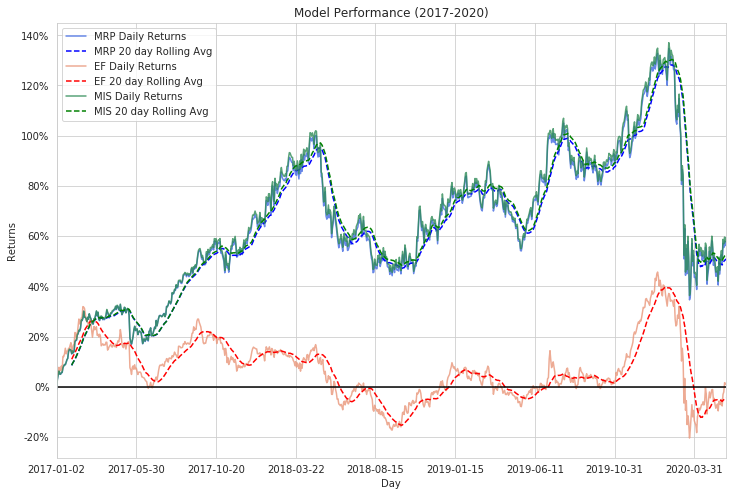

In [75]:
with sns.axes_style('whitegrid'):
    # initializes figure and axis
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)

    # gets xtick postions for datetime objects, set minimum number of xticks to 3
    xtick_locator = AutoDateLocator(minticks=3)

    # aesthetically formats xticks
    xtick_formatter = AutoDateFormatter(xtick_locator)

    # returns pretty seaborn plot of hedgecraft returns and its 20 day rolling avg
    daily_roi.plot(color='royalblue', alpha=0.8)
    rolling_20d_avg.plot(color='blue', ls='dashed')

    # returns pretty seaborn plot of EF returns and its 20 day rolling avg
    ef_daily_roi.plot(color='darksalmon', alpha=0.8)
    ef_rolling_20d_avg.plot(color='red', ls='dashed')

    # returns pretty seaborn plot of hedgecraft MIS returns and its 20 day rolling avg
    mis_daily_roi.plot(color='seagreen', alpha=0.8)
    mis_rolling_20d_avg.plot(color='green', ls='dashed')

    # renders xticks, sets ylabel, and turns legend on
    #ax.xaxis.set_major_locator(xtick_locator)
    #ax.xaxis.set_major_formatter(xtick_formatter)
    ax.set_title('Model Performance ({}-{})'.format(TEST_RANGE[0][:4], TEST_RANGE[1][:4]))
    ax.set_ylabel('Returns')
    ax.legend()

    # gets ytick labels and converts to pct format
    vals = ax.get_yticks()
    ax.set_yticklabels(['{:.0f}%'.format(x) for x in vals])

    # draws a horizontal line at 0, turns grid on
    plt.axhline(0, color='black');
    plt.tick_params(left=False, bottom=False)

Pictured above are the daily returns for Hedgecraft MIS (solid green curve), Hedgecraft (solid blue curve), and the Efficient Frontier portfolio (solid red curve) from January, 2019 to May, 2020. The color-coded dashed curves represent the 20 day rolling averages of the respective portfolios. 

Several observations pop: 

1. Efficient frontier performs well before the COVID-19 pandemia, but performs badly during the pandemia;
2. MIS is the opposite to EF;
3. Our risk portfolio `Close` shows more robusteness in the period, and obtain high returns during the pandemia period;
4. The results from Close and MIS suggests that this approach to minimize systemic risk performs well during crisis; and
5. It is good to note that the Brazilian market is not too stable in the recent years due to uncertainties in the political, economic, and social point of view.

Next, let's observe the annual returns for each portfolio and compare them with the market.

In [76]:
returns_summary

,MRP Returns,MIS Returns,Efficient Frontier Returns,Ibovespa Return Rates,SMLL Return Rates,MRP Return Rates,MIS Return Rates,Efficient Frontier Return Rates
2017,65.0%,66.3%,14.1%,26.86%,49.35%,65.0%,66.3%,14.1%
2018,70.0%,71.5%,2.3%,15.09%,8.13%,5.0%,5.2%,-11.8%
2019,117.5%,119.4%,31.7%,31.58%,58.20%,47.5%,47.9%,29.4%
2020,57.8%,59.4%,1.4%,-30.39%,-34.07%,-59.7%,-60.0%,-30.3%


In [204]:
returns_summary.to_csv("data/returns_summary.csv")

In comparison, the Ibovespa had a 26.86%, 15.09%, 31.58%, and -30.39% annual return rate in 2017, 2018, 2019, and 2020, respectively. The SMLL had a 49.35%, 8.13%, 58.20%, and -34.07% annual return rate in the same respective years. 

**MRP and MIS substantially outperformed both the market and the Efficient Frontier.** 
MRP and MIS substantially outperformed both the Ibovespa and SMLL indexes, as well as the Efficient Frontier. The higher returns, in theory, should be obtained with the trade-off of increasing the risk of the portfolio. But as we will see in the next section, this did not occur with our strategies.  

# Visualizing Drawdowns

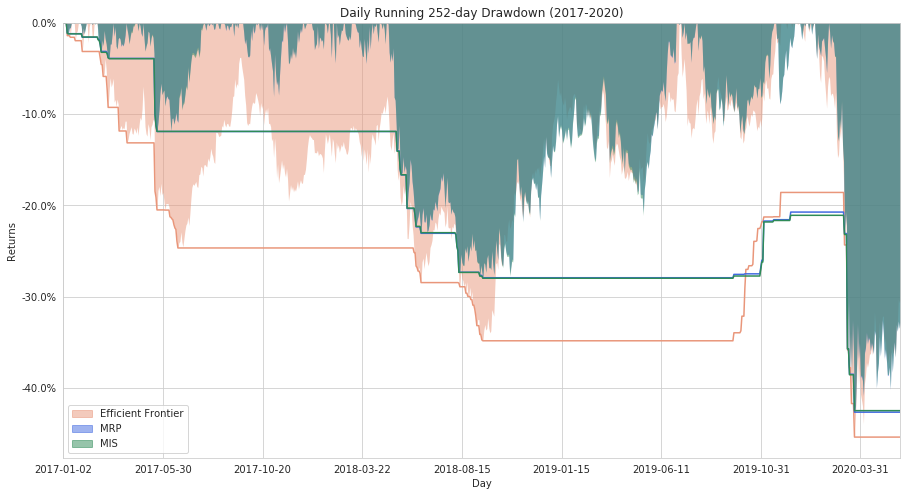

In [77]:
# imports tool to build legends
import matplotlib.patches as mpatches

with sns.axes_style('whitegrid'):
    # initializes figure and axis
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111)

    # gets xtick postions for datetime objects, set minimum number of xticks to 3
    xtick_locator = AutoDateLocator(minticks=3)

    # aesthetically formats xticks
    xtick_formatter = AutoDateFormatter(xtick_locator)

    ef_daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='darksalmon')
    ef_max_daily_drawdown.plot(color='darksalmon')

    daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='royalblue')
    max_daily_drawdown.plot(color='royalblue')

    mis_daily_drawdown.plot.area(ax=ax, linewidth=0, alpha=0.5, color='seagreen')
    mis_max_daily_drawdown.plot(color='seagreen')

    # renders xticks, sets ylabel, and turns legend on
    #ax.xaxis.set_major_locator(xtick_locator)
    #ax.xaxis.set_major_formatter(xtick_formatter)
    
    ax.set_ylabel('Returns')
    
    # sets legend patches color and labels
    ef_patch = mpatches.Patch(color='darksalmon', label='Efficient Frontier', alpha=0.5)
    patch = mpatches.Patch(color='royalblue', label='MRP', alpha=0.5)
    mis_patch = mpatches.Patch(color='seagreen', label='MIS', alpha=0.5)
    
    # turns legend on with patches
    plt.legend(handles=[ef_patch, patch, mis_patch])

    plt.tick_params(left=False, bottom=False)
    plt.title('Daily Running 252-day Drawdown ({}-{})'.format(TEST_RANGE[0][:4], TEST_RANGE[1][:4]))

     # gets ytick labels and converts to pct format
    vals = ax.get_yticks()
    ax.set_yticklabels([str(round(x*100,2)) + '%' for x in vals])

Illustrated above is the daily rolling 252-day drawdown for Close MIS (filled sea green curve), Close (filled royal blue curve), and the Efficient Frontier (filled dark salmon curve) along with the respective rolling maximum drawdowns (solid curves). 

Several observations stick out: 

1. the Close portfolios have significantly smaller drawdowns than the portfolio generated from the Efficient Frontier;
2. All portfolios have roughly the same maximum drawdown (about 45%);
3. Close on average lost the least amount of returns; and 
4. Close's rolling maximum drawdowns are, on average, less pronounced than Close MIS. These results suggest the communicability betweeness centrality has predictive power as a measure of relative or intraportfolio risk, and more generally, that network-based portfolio construction is a promosing alternative to the more traditional approaches like MPT. 

Next, let's observe how each portfolio performed with the metrics we discussed earlier.

In [78]:
max_daily_drawdown.describe()

count    841.000000
mean      -0.202467
std        0.103065
min       -0.426445
25%       -0.279157
50%       -0.215564
75%       -0.118973
max        0.000000
Name: MRP Cumulative Daily Returns, dtype: float64

In [79]:
mis_daily_drawdown.describe()

count    841.000000
mean      -0.099509
std        0.104658
min       -0.424770
25%       -0.161117
50%       -0.071179
75%       -0.011963
max        0.000000
Name: MIS Cumulative Daily Returns, dtype: float64

In [80]:
ef_daily_drawdown.describe()

count    841.000000
mean      -0.146402
std        0.093251
min       -0.453756
25%       -0.188730
50%       -0.126434
75%       -0.090045
max        0.000000
Name: EF Cumulative Daily Returns, dtype: float64

In [81]:
backtest_stats

,MRP,MIS,Efficient Frontier
Avg Annual Rate of Returns,0.74%,0.86%,-2.39%
Annual Volatility,30.82%,31.16%,33.5%
Maximum Drawdown,-42.64%,-42.48%,-45.38%
Annualized Sharpe Ratio,-0.04,-0.04,-0.13
Returns Over Maximum Drawdown,1.36,1.4,0.03
Growth-Risk Ratio,0.04,0.04,-0.09


In [211]:
backtest_stats.to_csv("data/backtest_stats.csv")

MRP and MIS outperformed the Efficient Froniter on every metric. These results suggests that our strategy has has potential to be used in a real-world investment. 

# Analyzing the Distribution of Returns

In [82]:
# probability of Hedgecraft losing money
prob_lose_money = (daily_roi[daily_roi < 0].shape[0] 
                       / daily_roi.shape[0]
)

# probability of EF losing money
ef_prob_lose_money = (ef_daily_roi[ef_daily_roi < 0].shape[0] 
                          / ef_daily_roi.shape[0]
)

# probability of Hedgecraft MIS losing money
mis_prob_lose_money = (mis_daily_roi[mis_daily_roi < 0].shape[0] 
                           / mis_daily_roi.shape[0]
)

# Hedgecraft rolling 30 day avg
rolling_30d_avg = (daily_roi.rename('MRP 30 day Rolling Avg')
                   .rolling(30)
                   .mean()
)

# EF rolling 30 day avg
ef_rolling_30d_avg = (ef_daily_roi.rename('EF 30 day Rolling Avg')
                      .rolling(30)
                      .mean()
)

# Hedgecraft MIS rolling 30 day avg
mis_rolling_30d_avg = (mis_daily_roi.rename('MIS 30 day Rolling Avg')
                       .rolling(30)
                       .mean()
)


# Hedgecraft rolling 50 day avg
rolling_50d_avg = (daily_roi.rename('MRP 50 day Rolling Avg')
                   .rolling(50)
                   .mean()
)

# EF rolling 50 day avg
ef_rolling_50d_avg = (ef_daily_roi.rename('EF 50 day Rolling Avg')
                      .rolling(50)
                      .mean()
)

# Hedgecraft MIS rolling 50 day avg
mis_rolling_50d_avg = (mis_daily_roi.rename('MIS 50 day Rolling Avg')
                       .rolling(50)
                       .mean()
)

# Hedgecraft rolling 90 day avg
rolling_90d_avg = (daily_roi.rename('MRP 90 day Rolling Avg')
                   .rolling(90)
                   .mean()
)

# EF rolling 90 day avg
ef_rolling_90d_avg = (ef_daily_roi.rename('EF 90 day Rolling Avg')
                      .rolling(90)
                      .mean()
)

# Hedgecraft MIS rolling 90 day avg
mis_rolling_90d_avg = (mis_daily_roi.rename('MIS 90 day Rolling Avg')
                       .rolling(90)
                       .mean()
)

# Hedgecraft list of rolling avgs
rolling_avg_list = [rolling_30d_avg, rolling_50d_avg, rolling_90d_avg]

# EF list of rolling avgs
ef_rolling_avg_list = [ef_rolling_30d_avg, ef_rolling_50d_avg, ef_rolling_90d_avg]

# Hedgecraft MIS list of rolling avgs
mis_rolling_avg_list = [mis_rolling_30d_avg, mis_rolling_50d_avg, mis_rolling_90d_avg]

# Hedgecraft probabilities of falling below 30, 50, and 90 day rolling averages
prob_below_rolling_avgs = []
for i in rolling_avg_list:
    (prob_below_rolling_avgs.append(daily_roi[daily_roi < i].shape[0] 
                                    / daily_roi.shape[0]))

# Efficient Frontier probabilities of falling below 30, 50, and 90 day rolling averages
ef_prob_below_rolling_avgs = []
for i in ef_rolling_avg_list:
    (ef_prob_below_rolling_avgs.append(ef_daily_roi[ef_daily_roi < i].shape[0] 
                                       / ef_daily_roi.shape[0]))

# Hedgecraft MIS probabilities of falling below 30, 50, and 90 day rolling averages
mis_prob_below_rolling_avgs = []
for i in mis_rolling_avg_list:
    (mis_prob_below_rolling_avgs.append(mis_daily_roi[mis_daily_roi < i].shape[0] 
                                        / mis_daily_roi.shape[0]))

# worst day for the Hedgecraft model
max_loss = min(daily_roi)

# worst day for the Efficient Frontier model
ef_max_loss = min(ef_daily_roi)

# worst day for the Hedgecraft MIS model
mis_max_loss = min(mis_daily_roi)

# avg amount of money lost by Hedgecraft when returns fell below 0%
mean_loss = daily_roi[daily_roi < 0].mean()

# avg amount of money lost by EF when returns fell below 0%
ef_mean_loss = ef_daily_roi[ef_daily_roi < 0].mean()

# avg amount of money lost by Hedgecraft MIS when returns fell below 0%
mis_mean_loss = mis_daily_roi[mis_daily_roi < 0].mean()

# Hedgecraft distribution of returns statistics
dist_stats = [
                prob_lose_money*100, 
                max_loss, 
                mean_loss, 
                prob_below_rolling_avgs[0]*100, 
                prob_below_rolling_avgs[1]*100, 
                prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
dist_stats = [str(round(x, 2)) + '%' for x in dist_stats]

# Ef distribution of returns statistics
ef_dist_stats = [
                    ef_prob_lose_money*100, 
                    ef_max_loss, ef_mean_loss, 
                    ef_prob_below_rolling_avgs[0]*100,
                    ef_prob_below_rolling_avgs[1]*100, 
                    ef_prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
ef_dist_stats = [str(round(x, 2)) + '%' for x in ef_dist_stats]

#  Hedgecraft MIS distribution of returns statistics
mis_dist_stats = [
                    mis_prob_lose_money*100, 
                    mis_max_loss, mis_mean_loss, 
                    mis_prob_below_rolling_avgs[0]*100,
                    mis_prob_below_rolling_avgs[1]*100, 
                    mis_prob_below_rolling_avgs[2]*100
]

# rounds above list and annotates with % sign
mis_dist_stats = [str(round(x, 2)) + '%' for x in mis_dist_stats]

# dictionary of distribution stats
dist_stats_summary = {
                        'MRP': dist_stats, 
                        'MIS': mis_dist_stats, 
                        'Efficient Frontier': ef_dist_stats
}

# converts above dict to a DataFrame
dist_stats_summary = pd.DataFrame.from_dict(dist_stats_summary)

# renames the indices
dist_stats_summary = dist_stats_summary.rename(index={
                                 0:'probability of losing money from initial investement', 
                                 1:'maximum loss',
                                 2:'mean loss',
                                 3:'Probability of falling bellow 30 day rolling avg',
                                 4:'Probability of falling bellow 50 day rolling avg',
                                 5:'Probability of falling bellow 90 day rolling avg'
                            }
);

# Visualizing the Distribution of Returns

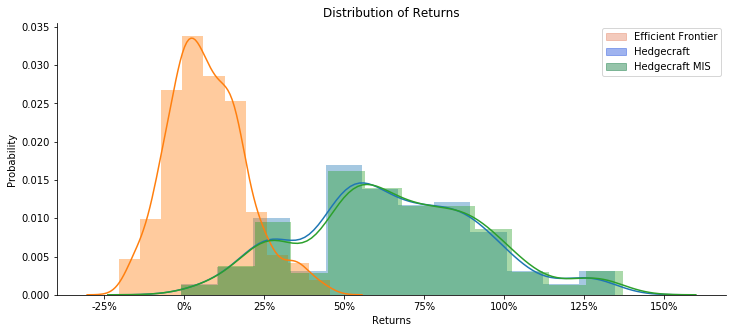

In [85]:
# function to plot many overlaping kde plots
def multi_distplot(rdist1, rdist2, rdist3, kde=True):
    
    # initializes figure and axis
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)

    # pretty seaborn kde plots for each model
    sns.distplot(rdist1, bins=12, kde=bool)
    sns.distplot(rdist2, bins=10, kde=bool)
    sns.distplot(rdist3, bins=12, kde=bool)
    
    # gets xticks
    vals1 = ax.get_xticks()
    
    # reformats xticks to pcts
    ax.set_xticklabels(['{:.0f}%'.format(x) for x in vals1])
    
    # plot labels and title
    ax.set_ylabel('Probability')
    ax.set_xlabel('Returns')
    plt.title('Distribution of Returns')
    
    # removes spines
    sns.despine(top=True, right=True)

    # sets legend patches color and labels
    ef_patch = mpatches.Patch(color='darksalmon', label='Efficient Frontier', alpha=0.5)
    patch = mpatches.Patch(color='royalblue', label='Hedgecraft', alpha=0.5)
    mis_patch = mpatches.Patch(color='seagreen', label='Hedgecraft MIS', alpha=0.5)
    
    # turns legend on with patches
    plt.legend(handles=[ef_patch, patch, mis_patch])
    
multi_distplot(rdist1 = daily_roi, rdist2 = ef_daily_roi, rdist3 = mis_daily_roi)
#multi_distplot(rdist1 = daily_roi, rdist2 = None, rdist3 = mis_daily_roi)

Above are the returns distribution for each portfolio: Efficient Frontier (in red), Close (in blue), and Close MIS (in green). The Efficient Frontier algorithm clearly produced a portfolio with a normal distribution of returns; the same can't be said of the Close portfolios.  

It's important to emphasize that deviation-based measures of risk-adjusted performance implicitly assume the distribution of returns follows a normal distribution. As such, the Sharpe ratio isn't a suitable measure of performance since the standard deviation isn't a suitable measure of risk for the Close portfolios.

In [86]:
dist_stats_summary

,MRP,MIS,Efficient Frontier
probability of losing money from initial investement,0.12%,0.12%,28.78%
maximum loss,-0.95%,-0.99%,-20.42%
mean loss,-0.95%,-0.99%,-6.05%
Probability of falling bellow 30 day rolling avg,34.96%,34.72%,49.11%
Probability of falling bellow 50 day rolling avg,36.39%,36.39%,47.68%
Probability of falling bellow 90 day rolling avg,33.65%,33.65%,47.68%


In [151]:
dist_stats_summary.to_csv("data/dist_stats_summary.csv")

# Conclusion

We designed an algorithm to generate a minimum risk portfolio (MRP) asset weights using tools from network science. First, an asset-related statistic is established, and then an appropriate centrality measure is used to extract the asset weight. As an intermediate step, we interpret the centrality score as a measure of relative risk because it captures asset volatility and their impact on the other assets in the network.

In addition, we designed a second strategy by allocating the capital by Maximal Independent Set (MIS). This strategy finds the subset of stocks that guarantee all the stocks in the network are connected. They are the most representative stocks.

Our strategies were compared with the Modern Portfolio Theory portfolio given by the Efficient Frontier (EF) method.

The portfolios were being assessed by cumulative return, rate of return, volatility, maximum withdrawal, risk-adjusted return, and risk-adjusted-performance. In all performance indicators, Hedgecra ȅ algorithm is significantly better than the Efficient frontier of the portfolio and market. 

**On all performance metrics, the MRP algorithm significantly outperformed both the portfolio generated by the Efficient Frontier and the market.**